In [59]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import csv
import json
import pandas as pd

In [10]:
def normalize(X_train):
   newx_train=tf.cast(X_train,tf.float32)/255
   
   return newx_train


In [116]:
def initialize_parameters():
    hidden_units=[(25,784),(15,25),(10,15)]
    parameters=dict()
    
    layers=len(hidden_units)
    
    initializer=tf.keras.initializers.HeNormal()
    
    for i in range(1,layers+1):
        parameters["W"+str(i)]=tf.Variable(initializer(shape=(hidden_units[i-1][0],hidden_units[i-1][1]))) 
        parameters["B"+str(i)]=tf.Variable(initializer(shape=(hidden_units[i-1][0],1)))
       
    return parameters
        

In [12]:
def convert_to_one_hot(label,depth=10):
    encoded=tf.one_hot(label,depth,axis=0)
    transformed_Y=tf.reshape(encoded,[depth,])
    
    return transformed_Y

In [37]:
def forward_propagation(X,parameters):
    
    layers=len(parameters)//2
    activations=dict()
    linearOutput=dict()
    
    activations["A0"]=X
    for i in range(1,layers+1):
        linearOutput["Z"+str(i)]=tf.add(tf.linalg.matmul(parameters["W"+str(i)],activations["A"+str(i-1)]),parameters["B"+str(i)])
        if i!=layers:
            activations["A"+str(i)]=tf.keras.activations.relu(linearOutput["Z"+str(i)])
        
        
        
    return linearOutput["Z"+str(layers)]

In [38]:
def losses(linear,y_labels):
    
    cost=tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_labels,linear))
    
    return cost


In [119]:
def model(X_train,Y_train,learning_rate=0.000001,num_epochs=150,minibatch_size=16,print_cost=True):
    costs=list()
    training_accuracies=list()
    
    parameters=initialize_parameters()
    optimizing_algo=tf.keras.optimizers.Adam(learning_rate)
    accuracy=tf.keras.metrics.CategoricalAccuracy()
    trainingSet=tf.data.Dataset.zip((X_train,Y_train))
    minibatches=trainingSet.batch(minibatch_size).prefetch(8)
    
    m=trainingSet.cardinality().numpy()
    
    W1=parameters["W1"]
    B1=parameters["B1"]
    W2=parameters["W2"]
    B2=parameters["B2"]
    W3=parameters["W3"]
    B3=parameters["B3"]
    
    
    for e in range(1,num_epochs+1):
        epochCost=0
        accuracy.reset_states()
        
        for (mini_X,mini_Y) in minibatches:
            with tf.GradientTape() as t:
                linearOutput=forward_propagation(tf.transpose(mini_X),parameters)
                
                mini_loss=losses(tf.transpose(linearOutput),mini_Y)
            accuracy.update_state(mini_Y,tf.transpose(linearOutput))
            
            training_parameters=[W1,B1,W2,B2,W3,B3]
            gradients=t.gradient(mini_loss,training_parameters)
            optimizing_algo.apply_gradients(zip(gradients,training_parameters))
            
            epochCost+=mini_loss
        epochCost/=m
        
        if print_cost==True and e%10==0:   
            print("Cost after epoch",e,"-",epochCost)
            print("Training accuracy - ",accuracy.result())
            
            costs.append(epochCost)
            training_accuracies.append(accuracy.result())
    return parameters,costs,training_accuracies

In [93]:

#main
train_set=pd.read_csv("train.csv")
test_set=pd.read_csv("test.csv")

In [94]:
x_train=tf.data.Dataset.from_tensor_slices(train_set.drop('label',axis=1))
y_train=tf.data.Dataset.from_tensor_slices(train_set['label'])

In [99]:
x_new_train=x_train.map(normalize)

In [100]:
y_new_train=y_train.map(convert_to_one_hot)

In [122]:
p,c,a=model(x_new_train,y_new_train)

Cost after epoch 10 - tf.Tensor(0.44034058, shape=(), dtype=float32)
Training accuracy -  tf.Tensor(0.059261903, shape=(), dtype=float32)
Cost after epoch 20 - tf.Tensor(0.43355998, shape=(), dtype=float32)
Training accuracy -  tf.Tensor(0.06107143, shape=(), dtype=float32)
Cost after epoch 30 - tf.Tensor(0.42501026, shape=(), dtype=float32)
Training accuracy -  tf.Tensor(0.06397619, shape=(), dtype=float32)
Cost after epoch 40 - tf.Tensor(0.41755688, shape=(), dtype=float32)
Training accuracy -  tf.Tensor(0.06607143, shape=(), dtype=float32)
Cost after epoch 50 - tf.Tensor(0.40756288, shape=(), dtype=float32)
Training accuracy -  tf.Tensor(0.06945238, shape=(), dtype=float32)
Cost after epoch 60 - tf.Tensor(0.3984984, shape=(), dtype=float32)
Training accuracy -  tf.Tensor(0.07252381, shape=(), dtype=float32)
Cost after epoch 70 - tf.Tensor(0.38926408, shape=(), dtype=float32)
Training accuracy -  tf.Tensor(0.07669047, shape=(), dtype=float32)
Cost after epoch 80 - tf.Tensor(0.3815514

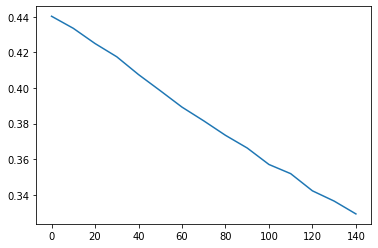

In [123]:
costs=np.array(c)
accuracy=np.array(a)

iter=np.arange(0,150,10)

plt.plot(iter,costs)


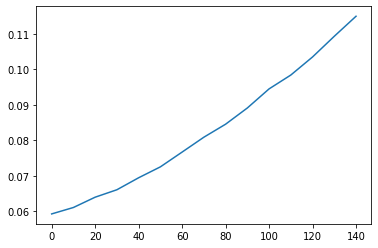

In [124]:
plt.plot(iter,accuracy)